## Image classification with Convolutional Neural Networks

This is the minimal set of steps required to run an image classification task between two classes.

We will try to differentiate harbour seals & California sea lions.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
from fastai.imports import os, np, plt, PIL
from fastai.transforms import transforms_side_on, transforms_from_model
from fastai.conv_learner import ConvLearner, accuracy_np
from fastai.model import resnet34, torch
from fastai.dataset import ImageClassifierData

In [3]:
# Sanity checks for GPU - both should return true
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [4]:
PATH = '/home/paperspace/data/seal_or_sealion/'
sz = 224
data = ImageClassifierData.from_paths(PATH, transforms = transforms_from_model(resnet34, sz))
my_model = ConvLearner.pretrained(resnet34, data)
my_model.lr_find(start_lr = 1e-5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.81669    399.367218 0.69308   



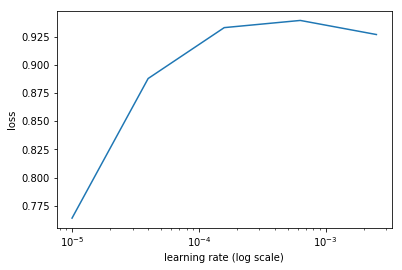

In [5]:
my_model.sched.plot(0)

In [6]:
learning_rate = 1e-3
# First train with precomputed activations
my_model = ConvLearner.pretrained(resnet34, data)
my_model.fit(learning_rate, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.897229   0.571131   0.736607  
    1      0.810269   0.432253   0.834821                 
    2      0.712849   0.321477   0.876116         
    3      0.643055   0.265278   0.883929                 
    4      0.582794   0.233861   0.899554                 



[0.23386109, 0.8995535671710968]

In [7]:
# Now train without precomputed activations & use image augmentation
# Since data was set up with image augmentation, we just need to set precompute = False

my_model_without_precompute = ConvLearner.pretrained(resnet34, data, precompute=False)
my_model_without_precompute.fit(learning_rate, 7)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.885465   0.596709   0.695312  
    1      0.801098   0.427768   0.860491                 
    2      0.740096   0.334632   0.883929                 
    3      0.670714   0.276267   0.935268                 
    4      0.600396   0.250597   0.935268                 
    5      0.545087   0.223448   0.94308                  
    6      0.501948   0.212369   0.935268                 



[0.21236876, 0.9352678656578064]

In [8]:
# Now unfreeze all layers & train with multiple cycles

my_model_without_precompute.unfreeze()
learning_rate_array=np.array([learning_rate/100, learning_rate/10, learning_rate])
my_model_without_precompute.fit(learning_rate_array, 5, cycle_len=1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.47353    0.249875   0.927455  
    1      0.469708   0.237095   0.935268                 
    2      0.433876   0.238178   0.935268                  
    3      0.410956   0.219113   0.953125                  
    4      0.388174   0.204098   0.935268                  
    5      0.364269   0.196444   0.927455                  
    6      0.35653    0.195545   0.935268                  
    7      0.360905   0.176943   0.953125                  
    8      0.342528   0.168663   0.953125                  
    9      0.320931   0.16422    0.945312                  
    10     0.307928   0.157752   0.953125                  
    11     0.290957   0.157814   0.953125                  
    12     0.274859   0.154532   0.953125                  
    13     0.275711   0.154406   0.96875                   
    14     0.265564   0.153587   0.945312                  
    15     0.256834   0.148564   0.945312                

[0.12329777, 0.9609375]

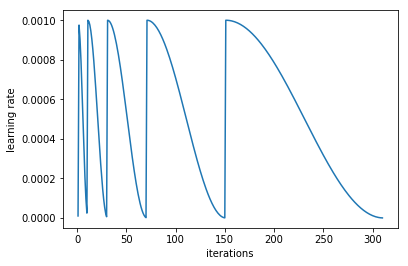

In [9]:
my_model_without_precompute.sched.plot_lr()

## View results

In [10]:
# Predict for validation set
log_preds,y = my_model_without_precompute.TTA()

In [11]:
print(log_preds[0].shape)
log_preds[0][:10]

(92, 2)


array([[-0.0707 , -2.68443],
       [-0.2146 , -1.64436],
       [-1.55237, -0.23793],
       [-0.15372, -1.94848],
       [-0.02592, -3.66569],
       [-0.63972, -0.74959],
       [-0.17587, -1.82464],
       [-0.04202, -3.19066],
       [-0.02469, -3.71373],
       [-0.00289, -5.84769]], dtype=float32)

In [18]:
preds = np.argmax(log_preds[0], axis=1)  # from log probabilities to 0 or 1
#probs = np.exp(log_preds[:,1])        # pr(class1)
mean_probs = np.mean(np.exp(log_preds), 0)
accuracy_np(mean_probs, y)
probs = mean_probs[:,1]

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [21]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [25]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.filenames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


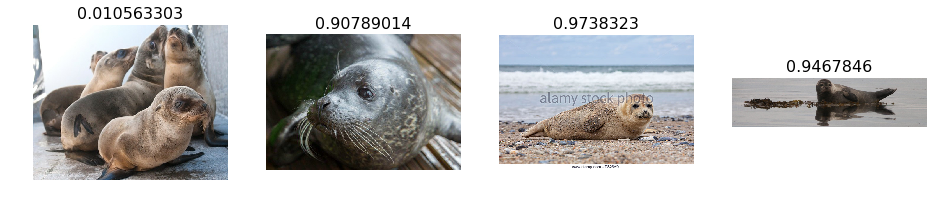

In [26]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


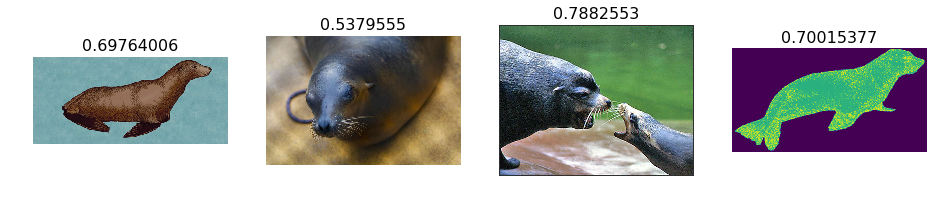

In [27]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [28]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct sea lions


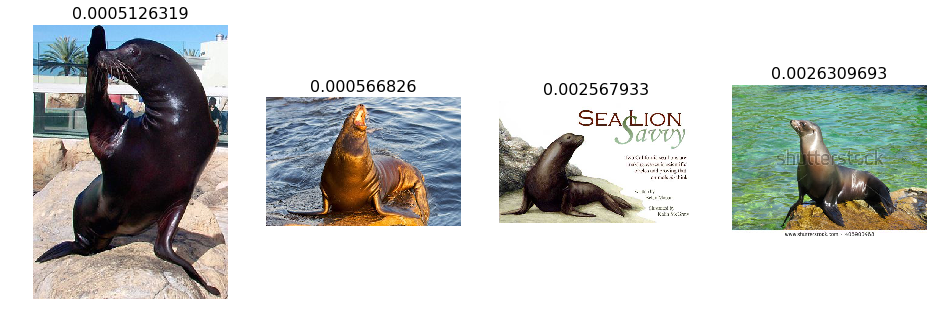

In [29]:
plot_val_with_title(most_by_correct(0, True), "Most correct sea lions")

Most correct seals


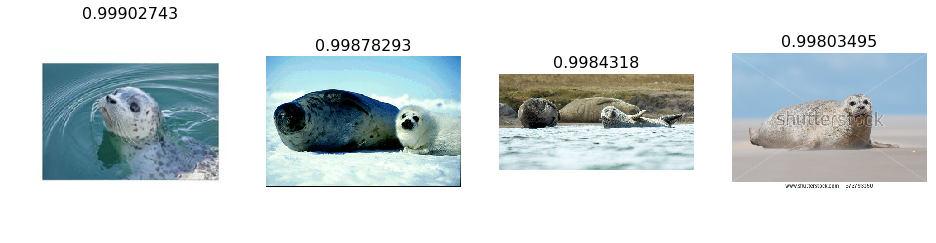

In [30]:
plot_val_with_title(most_by_correct(1, True), "Most correct seals")

Most incorrect sea lions


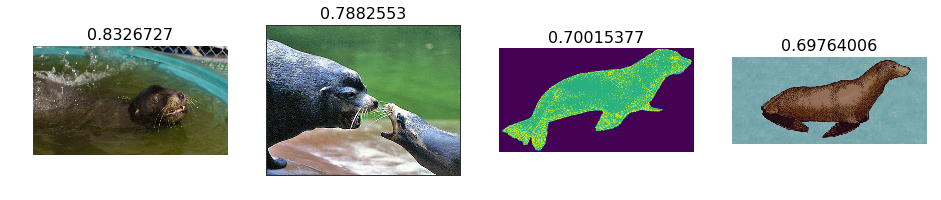

In [31]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect sea lions")

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect seals")

Most incorrect seals


Most uncertain predictions


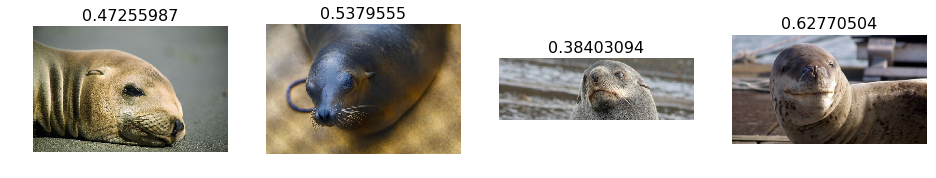

In [34]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

[[45  5]
 [ 0 42]]


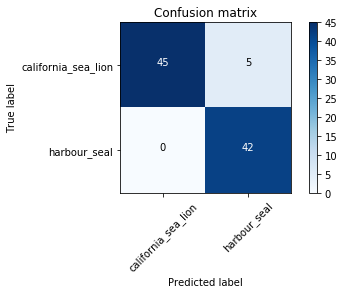

In [35]:
preds = np.argmax(mean_probs, axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
from fastai.plots import plot_confusion_matrix
plot_confusion_matrix(cm, data.classes)